# Here we evaluate what the size of the effect could be from close orbit distorltions

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
basedir = "/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

## Get trolley data of NQ and SQ for the 60 hour dataset
### Load another pickel file that was made from a script in another repository called multipoles_vs_phi

In [3]:
path = basedir + 'field_info/data/df_trolley.pkl'
df_tr = pd.read_pickle(path)

#extend the position out to N turns
N=3
df_base = df_tr.copy()
for n in range(1,N):
    df_ext = df_base.copy()
    df_ext['pos'] = df_ext['pos'] + 360*n
    df_tr = pd.concat([df_tr,df_ext], axis=0)

#convert deg to rad
df_tr['pos'] = df_tr['pos']*np.pi/180.0
#convert from nq and sq at 45 cm to at 1 cm
df_tr['NQ'] = df_tr['NQ']/45.0
df_tr['SQ'] = df_tr['SQ']/45.0


## Now eval the effect of various beam oscilations
### Generate a sine wave and evaluate it at each pos point

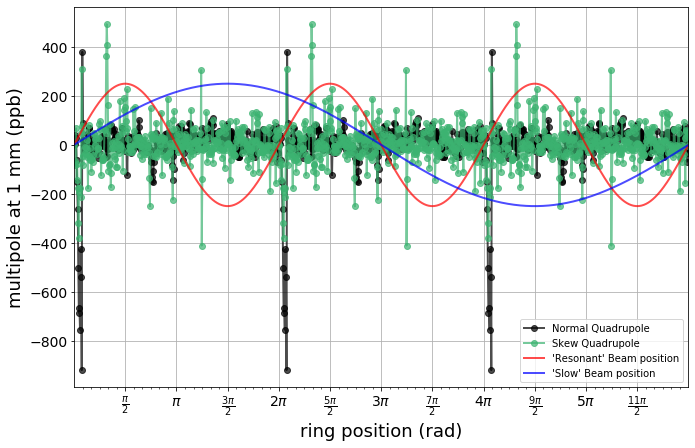

In [4]:
#calculate
freq = 1
phase = 0
amp = 250 #1 mm
df_tr['sin'] = amp*np.sin(freq*df_tr['pos'] + phase)
df_tr['sin_sl'] = amp*np.sin(freq*df_tr['pos']/3 + phase)
#plot
sty = ['-o','-o','-','-']
yy = ['NQ','SQ','sin','sin_sl']
leg = ["Normal Quadrupole",'Skew Quadrupole',
       "'Resonant' Beam position","'Slow' Beam position"]
c = ['black','mediumseagreen','red','blue']
ax = df_tr.plot(x='pos',y=yy,style=sty,figsize=(11,7),alpha=0.7,linewidth=2,color=c)
plt.xlabel("ring position (rad)",fontsize=18)
plt.ylabel("multipole at 1 mm (ppb)",fontsize=18)
plt.legend(prop={'size': 19})
ax.legend(leg)
plt.grid()
#make x axis show multiples of pi
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
#make the font size big for the ticks on x and y
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
plt.show()

### take the sine multipled average

In [5]:
NQ_bare = df_tr['NQ'].mean()
SQ_bare = df_tr['SQ'].mean()
NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
print(NQ_bare)
print(SQ_bare)
print(NQ_avg)
print(SQ_avg)

-0.4244384817656493
1.6885513511766488
-1945.2956289880865
688.4997433287034


### Do the same but for a variety of phases

In [6]:
#setup to store the values 
NQ_vec_res = np.empty(0)
SQ_vec_res = np.empty(0)
NQ_vec_fast = np.empty(0)
SQ_vec_fast = np.empty(0)
NQ_vec_med = np.empty(0)
SQ_vec_med = np.empty(0)
NQ_vec_slow = np.empty(0)
SQ_vec_slow = np.empty(0)

#setup the beam function
freq = 1.0
amp = 1 #1 mm
phases = np.arange(0,360,30)*np.pi/180.0

#do the loop
for phase in phases:
    #first the resonant oscilation
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos'] + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_res = np.append(NQ_vec_res,NQ_avg)
    SQ_vec_res = np.append(SQ_vec_res,SQ_avg)
    
    #first the fast oscilation
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos']*2.0 + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_fast = np.append(NQ_vec_fast,NQ_avg)
    SQ_vec_fast = np.append(SQ_vec_fast,SQ_avg)
    
    #next the med oscilation (lower frequency)
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos']/2.0 + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_med = np.append(NQ_vec_med,NQ_avg)
    SQ_vec_med = np.append(SQ_vec_med,SQ_avg)
    
    #next the slow oscilation (lowest frequency)
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos']/4.0 + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_slow = np.append(NQ_vec_slow,NQ_avg)
    SQ_vec_slow = np.append(SQ_vec_slow,SQ_avg)

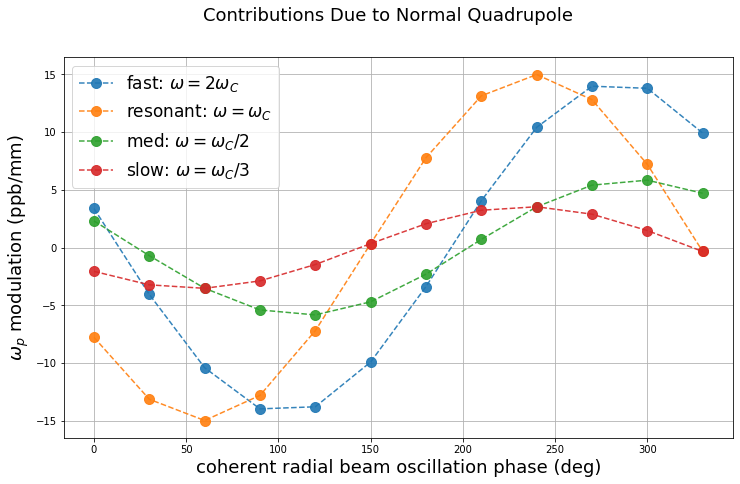

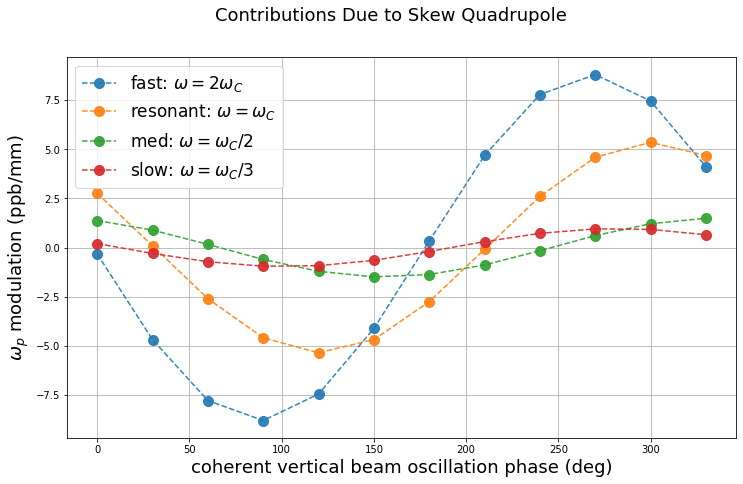

In [7]:
phases = phases*180.0/np.pi
#radial plot
fig = plt.figure(figsize=(12,7))
fig.suptitle('Contributions Due to Normal Quadrupole',fontsize=18)
plt.plot(phases,NQ_vec_fast,'o--',label='fast: $\omega = 2\omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,NQ_vec_res,'o--', label='resonant: $\omega = \omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,NQ_vec_med,'o--', label='med: $\omega = \omega_C/2$',alpha=0.9,markersize=10)
plt.plot(phases,NQ_vec_slow,'o--', label='slow: $\omega = \omega_C/3$',alpha=0.9,markersize=10)
plt.xlabel("coherent radial beam oscillation phase (deg)",fontsize=18)
plt.ylabel(r"$\omega_p$ modulation (ppb/mm)",fontsize=18)
plt.legend(prop={'size': 17})
plt.grid()
plt.show()
#vertical plot
fig = plt.figure(figsize=(12,7))  
fig.suptitle('Contributions Due to Skew Quadrupole',fontsize=18)
plt.plot(phases,SQ_vec_fast,'o--',label='fast: $\omega = 2\omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,SQ_vec_res,'o--', label='resonant: $\omega = \omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,SQ_vec_med,'o--', label='med: $\omega = \omega_C/2$',alpha=0.9,markersize=10)
plt.plot(phases,SQ_vec_slow,'o--', label='slow: $\omega = \omega_C/3$',alpha=0.9,markersize=10)
plt.xlabel("coherent vertical beam oscillation phase (deg)",fontsize=18)
plt.ylabel(r"$\omega_p$ modulation (ppb/mm)",fontsize=18)
plt.legend(prop={'size': 17})
plt.grid()
plt.show()


# Do the same thing, but cut out the bad inflector readings

In [8]:
mini = -150
mask = df_tr['NQ'] > mini
df_tr = df_tr[mask]
# df_tr.loc[mask,'NQ'] = 0
mask = df_tr['SQ'] > mini
df_tr = df_tr[mask]
# df_tr.loc[mask,'SQ'] = 0

maxi = 150
mask = df_tr['NQ'] < maxi
df_tr = df_tr[mask]
# df_tr.loc[mask,'NQ'] = 0
mask = df_tr['SQ'] < maxi
df_tr = df_tr[mask]
# df_tr.loc[mask,'SQ'] = 0

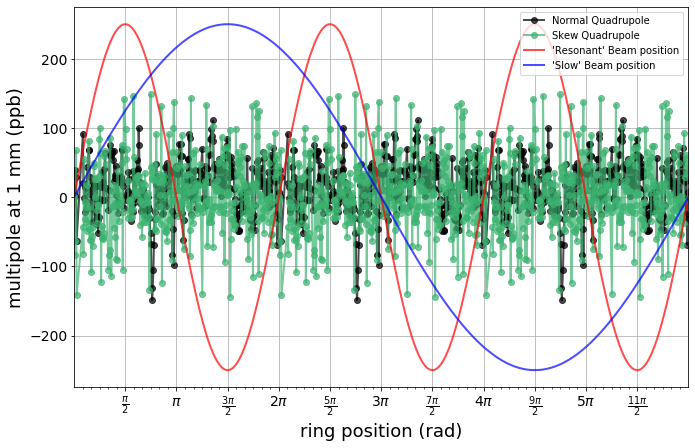

In [9]:
#calculate
freq = 1
phase = 0
amp = 250 #1 mm
df_tr['sin'] = amp*np.sin(freq*df_tr['pos'] + phase)
df_tr['sin_sl'] = amp*np.sin(freq*df_tr['pos']/3 + phase)
#plot
sty = ['-o','-o','-','-']
yy = ['NQ','SQ','sin','sin_sl']
leg = ["Normal Quadrupole",'Skew Quadrupole',
       "'Resonant' Beam position","'Slow' Beam position"]
c = ['black','mediumseagreen','red','blue']
ax = df_tr.plot(x='pos',y=yy,style=sty,figsize=(11,7),alpha=0.7,linewidth=2,color=c)
plt.xlabel("ring position (rad)",fontsize=18)
plt.ylabel("multipole at 1 mm (ppb)",fontsize=18)
plt.legend(prop={'size': 19})
ax.legend(leg)
plt.grid()
#make x axis show multiples of pi
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
#make the font size big for the ticks on x and y
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
plt.show()

In [10]:
#setup to store the values 
NQ_vec_res = np.empty(0)
SQ_vec_res = np.empty(0)
NQ_vec_fast = np.empty(0)
SQ_vec_fast = np.empty(0)
NQ_vec_med = np.empty(0)
SQ_vec_med = np.empty(0)
NQ_vec_slow = np.empty(0)
SQ_vec_slow = np.empty(0)

#setup the beam function
freq = 1.0
amp = 1 #1 mm
phases = np.arange(0,360,30)*np.pi/180.0

#do the loop
for phase in phases:
    #first the resonant oscilation
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos'] + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_res = np.append(NQ_vec_res,NQ_avg)
    SQ_vec_res = np.append(SQ_vec_res,SQ_avg)
    
    #first the fast oscilation
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos']*2.0 + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_fast = np.append(NQ_vec_fast,NQ_avg)
    SQ_vec_fast = np.append(SQ_vec_fast,SQ_avg)
    
    #next the med oscilation (lower frequency)
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos']/2.0 + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_med = np.append(NQ_vec_med,NQ_avg)
    SQ_vec_med = np.append(SQ_vec_med,SQ_avg)
    
    #next the slow oscilation (lowest frequency)
    df_tr['sin'] = amp*np.sin(freq*df_tr['pos']/3.0 + phase)
    NQ_avg = (df_tr['NQ']*df_tr['sin']).mean()
    SQ_avg = (df_tr['SQ']*df_tr['sin']).mean()
    NQ_vec_slow = np.append(NQ_vec_slow,NQ_avg)
    SQ_vec_slow = np.append(SQ_vec_slow,SQ_avg)

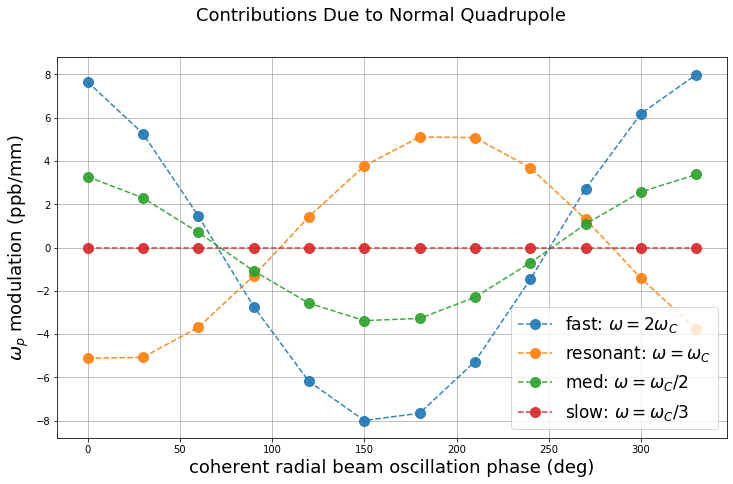

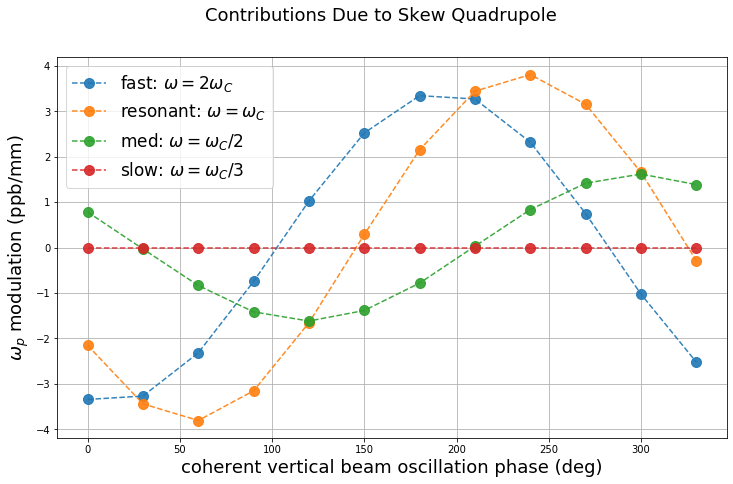

In [11]:
phases = phases*180.0/np.pi
#radial plot
fig = plt.figure(figsize=(12,7))
fig.suptitle('Contributions Due to Normal Quadrupole',fontsize=18)
plt.plot(phases,NQ_vec_fast,'o--',label='fast: $\omega = 2\omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,NQ_vec_res,'o--', label='resonant: $\omega = \omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,NQ_vec_med,'o--', label='med: $\omega = \omega_C/2$',alpha=0.9,markersize=10)
plt.plot(phases,NQ_vec_slow,'o--', label='slow: $\omega = \omega_C/3$',alpha=0.9,markersize=10)
plt.xlabel("coherent radial beam oscillation phase (deg)",fontsize=18)
plt.ylabel(r"$\omega_p$ modulation (ppb/mm)",fontsize=18)
plt.legend(prop={'size': 17})
plt.grid()
plt.show()
#vertical plot
fig = plt.figure(figsize=(12,7))  
fig.suptitle('Contributions Due to Skew Quadrupole',fontsize=18)
plt.plot(phases,SQ_vec_fast,'o--',label='fast: $\omega = 2\omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,SQ_vec_res,'o--', label='resonant: $\omega = \omega_C$',alpha=0.9,markersize=10)
plt.plot(phases,SQ_vec_med,'o--', label='med: $\omega = \omega_C/2$',alpha=0.9,markersize=10)
plt.plot(phases,SQ_vec_slow,'o--', label='slow: $\omega = \omega_C/3$',alpha=0.9,markersize=10)
plt.xlabel("coherent vertical beam oscillation phase (deg)",fontsize=18)
plt.ylabel(r"$\omega_p$ modulation (ppb/mm)",fontsize=18)
plt.legend(prop={'size': 17})
plt.grid()
plt.show()